# Master jupyter notebook for LANL - SlimBros Team

Correctly predicting earthquakes is very important for preventing deaths and damage to infrastructure. In this competition we try to predict time left to the next laboratory earthquake based on seismic signal data. Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

## Preliminaries
Let's import everything we need:

In [1]:
import os
import gc
import eli5
import csv
import dill
import time
import random
import datetime
import warnings
import feather

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from catboost import CatBoostRegressor
from sklearn import svm, neighbors, linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GridSearchCV, cross_val_score, ParameterGrid, train_test_split
from utils import generate_segment_start_ids, compare_methods
from features import gpi, create_all_features_extended
from features import gpi_new, gpii_new, gpiii_new
from features import gpi_tiny, gpii_tiny

#Configure the environment
%matplotlib inline
pd.options.display.precision = 15
warnings.filterwarnings('ignore')
random.seed(1013)

Load/compute the necessary features

In [2]:
compute_features = False 
# The computed features are saved in an hdf file along with the time_to_failure to 
# save the time spend reading the training data and the feature computation
#train_data_format = 'csv'
train_data_format = 'feather'

## Training data

In [3]:
def load_train_data(file_format):
    """Load the training dataset."""
    print(f"Loading data from {file_format} file:", end="")
    if file_format.lower() == 'feather':
        train_df = feather.read_dataframe('../input/train.feather')
    else:
        train_df = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16,
                                                            'time_to_failure': np.float32})
        feather.write_dataframe(train_df, '../input/train.feather')
    print("Done")
    return train_df

In [4]:
train = load_train_data(train_data_format)

Loading data from feather file:Done


In [5]:
time_to_failure_delta = np.diff(train['time_to_failure'])
init_times = np.where(time_to_failure_delta > 5)[0].tolist()
print(f"There are {len(init_times)} quakes on the training set.")

There are 16 quakes on the training set.


Let's discard any quake that looks weird

## Feature generation
- Usual aggregations: mean, std, min and max;
- Average difference between the consequitive values in absolute and percent values;
- Absolute min and max vallues;
- Aforementioned aggregations for first and last 10000 and 50000 values - I think these data should be useful;
- Max value to min value and their differencem also count of values bigger that 500 (arbitrary threshold);
- Quantile features from this kernel: https://www.kaggle.com/andrekos/basic-feature-benchmark-with-quantiles
- Trend features from this kernel: https://www.kaggle.com/jsaguiar/baseline-with-abs-and-trend-features
- Rolling features from this kernel: https://www.kaggle.com/wimwim/rolling-quantiles

In [10]:
#features_version = ''
#features_version = 'v2'
features_version = 'v3'

In [11]:
saved_files_present = (os.path.isfile(f'../tmp_results/X{features_version}_tr.hdf') and 
                       os.path.isfile(f'../tmp_results/X{features_version}_test.hdf') and 
                       os.path.isfile(f'../tmp_results/y{features_version}_tr.hdf') )

In [12]:
if saved_files_present:
    print(f'The files containing the features ({features_version}) already exist.')
else:
    print(f'The files containing the features ({features_version}) do not exist')
    print(f'In the following step, the features will be computed. This may take several hours.')

The files containing the features (v3) already exist.


In [16]:
if (not compute_features) and saved_files_present:
    print(f'Reading hdf files ({features_version}): ', end="")
    X_tr = pd.read_hdf(f'../tmp_results/X{features_version}_tr.hdf', 'data')
    X_test = pd.read_hdf(f'../tmp_results/X{features_version}_test.hdf', 'data')
    y_tr = pd.read_hdf(f'../tmp_results/y{features_version}_tr.hdf', 'data')  
    print("Done")
else:
    fs = 4000000 #Sampling frequency of the raw signal

    #Compute features for the training data
    segment_size = 150000
    segment_start_ids = generate_segment_start_ids('uniform_no_jump', segment_size, train)
    X_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64)
    y_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64, columns=['time_to_failure'])
    for idx in tqdm_notebook(range(len(segment_start_ids))):        
        seg_id = segment_start_ids[idx]
        seg = train.iloc[seg_id:seg_id + segment_size]
        create_all_features_extended(idx, seg, X_tr, fs)
        y_tr.loc[idx, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    # Sanity check
    means_dict = {}
    for col in X_tr.columns:
        if X_tr[col].isnull().any():
            print(col)
            mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
            X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
            X_tr[col] = X_tr[col].fillna(mean_value)
            means_dict[col] = mean_value

    #Compute features for the test data
    submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
    X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
    for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
        seg = pd.read_csv('../input/test/' + seg_id + '.csv')
        create_all_features_extended(seg_id, seg, X_test, fs)

    # Sanity check
    for col in X_test.columns:
        if X_test[col].isnull().any():
            X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
            X_test[col] = X_test[col].fillna(means_dict[col])
            
    X_tr.to_hdf(f'../tmp_results/X{features_version}_tr.hdf', 'data')
    X_test.to_hdf(f'../tmp_results/X{features_version}_test.hdf', 'data')
    y_tr.to_hdf(f'../tmp_results/y{features_version}_tr.hdf', 'data')
    
    del segment_start_ids
    del means_dict
    del submission
    
    print("Done")

Reading hdf files (v3): Done


## Scale data

In [17]:
alldata = pd.concat([X_tr, X_test])
scaler = StandardScaler()
alldata = pd.DataFrame(scaler.fit_transform(alldata), columns=alldata.columns)
X_train_scaled = alldata[:X_tr.shape[0]]
X_test_scaled = alldata[X_tr.shape[0]:]

## Building models

In [18]:
def train_model(X, X_test, y, folds, params=None, model_type='lgb',
                model=None, show_scatter=False, force_positive=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    n_fold = folds.get_n_splits()
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        if model_type == 'nn':
            dropout = params['dropout']
            num_layers = params['num_layers']
            num_neurons = params['num_neurons']
            activation_function = params['activation_function']
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Dense(1024, input_dim=216, activation=activation_function))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(dropout))
            for l in range(num_layers):
                model.add(tf.keras.layers.Dense(num_neurons, activation=activation_function))
                model.add(tf.keras.layers.BatchNormalization())
                model.add(tf.keras.layers.Dropout(dropout))
            model.add(tf.keras.layers.Dense(1))
            model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
            EPOCHS = 1000
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)

            history = model.fit(
                X_train,
                y_train,
                epochs=EPOCHS,
                validation_data = (X_valid, y_valid), 
                verbose=0,
                callbacks=[early_stop, PrintDot()])
            hist = pd.DataFrame(history.history)
            val_score = hist['val_mean_absolute_error'].iloc[-1]
            print(f'val_score={val_score}')
            plot_history(history)
        
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
          
            y_pred = model.predict(X_test).reshape(-1,)

            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric='mae',
                      verbose=10000,
                      early_stopping_rounds=2000)
            
            y_pred_valid = model.predict(X_valid)
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
          
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data,
                              num_boost_round=20000,
                              evals=watchlist,
                              early_stopping_rounds=200,
                              verbose_eval=500,
                              params=params)

            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns),
                                         ntree_limit=model.best_ntree_limit)
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
          
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns),
                                   ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
                
            score = mean_absolute_error(y_valid, y_pred_valid)
            y_pred = model.predict(X_test).reshape(-1,)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', task_type='GPU', **params)
            model.fit(X_train,
                      y_train,
                      eval_set=(X_valid, y_valid),
                      cat_features=[],
                      use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)

            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)

        if model_type == 'gpi':
            y_pred_valid = gpi(X_valid, activation=params['activation']).values
            y_pred = gpi(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)

        if model_type == 'gpi_new':
            y_pred_valid = gpi_new(X_valid, activation=params['activation']).values
            y_pred = gpi_new(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
            
        if model_type == 'gpii_new':
            y_pred_valid = gpii_new(X_valid, activation=params['activation']).values
            y_pred = gpii_new(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
                
        if model_type == 'gpiii_new':
            y_pred_valid = gpiii_new(X_valid, activation=params['activation']).values
            y_pred = gpiii_new(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
                
        if model_type == 'gpi_tiny':
            y_pred_valid = gpi_tiny(X_valid, activation=params['activation']).values
            y_pred = gpi_tiny(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
                
        if model_type == 'gpii_tiny':
            y_pred_valid = gpii_tiny(X_valid, activation=params['activation']).values
            y_pred = gpii_tiny(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance['feature'] = X.columns
            fold_importance['importance'] = model.feature_importances_
            fold_importance['fold'] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    if force_positive:
        prediction = prediction.clip(min=0)    
    
    if show_scatter:
        fig, axis = plt.subplots(1, 2, figsize=(12,5))
        ax1, ax2 = axis
        ax1.set_xlabel('actual')
        ax1.set_ylabel('predicted')
        ax2.set_xlabel('train index')
        ax2.set_ylabel('time to failure')
        
        ax1.scatter(y, oof, color='brown')
        ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')

        ax2.plot(y, color='blue', label='y_train')
        ax2.plot(oof, color='orange')
    
    print(f'CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}.')
    
    if model_type == 'lgb':
        feature_importance['importance'] /= n_fold
        return oof, prediction, scores, feature_importance
    else:
        return oof, prediction, scores

In [19]:
n_fold = 5
folds_models = KFold(n_splits=n_fold, shuffle=True, random_state=13)

Let's try a few different models and submit the one with the best validation score. The predicted values in the following plots are using a out-of-fold scheme.

### LGBM (Gradient Boosting)

In [32]:
params_lgb = {
    "objective": "huber",
    "boosting": "gbdt",
    "verbosity": -1,
    "num_leaves": 12,
    "min_data_in_leaf": 40,
    "max_depth": 8,
    "learning_rate": 0.005,
    "bagging_freq": 4,
    "bagging_fraction": 0.6,
    "bagging_seed": 11,
    "random_seed": 19,
    "metric": "mae",
    "reg_alpha": 0.47777777777777775,
    "reg_lambda": 0.47777777777777775
}

In [33]:
oof_lgb, prediction_lgb, scores_lgb, feature_importance_lgb = train_model(X=X_train_scaled,
                                                                          X_test=X_test_scaled,
                                                                          y=y_tr,
                                                                          folds=folds_models,
                                                                          params=params_lgb,
                                                                          model_type='lgb',
                                                                          show_scatter=False)

Fold 0 started at Sun May 12 10:28:46 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[3360]	training's l1: 1.47072	valid_1's l1: 2.01001
Fold 1 started at Sun May 12 10:30:11 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2892]	training's l1: 1.54379	valid_1's l1: 2.00792
Fold 2 started at Sun May 12 10:31:28 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2860]	training's l1: 1.52532	valid_1's l1: 2.09051
Fold 3 started at Sun May 12 10:32:46 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2828]	training's l1: 1.58469	valid_1's l1: 1.85874
Fold 4 started at Sun May 12 10:34:02 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2616]	training's l1: 1.574	valid_1's l1: 2.05764
CV mean score: 2.0050, std: 0.07

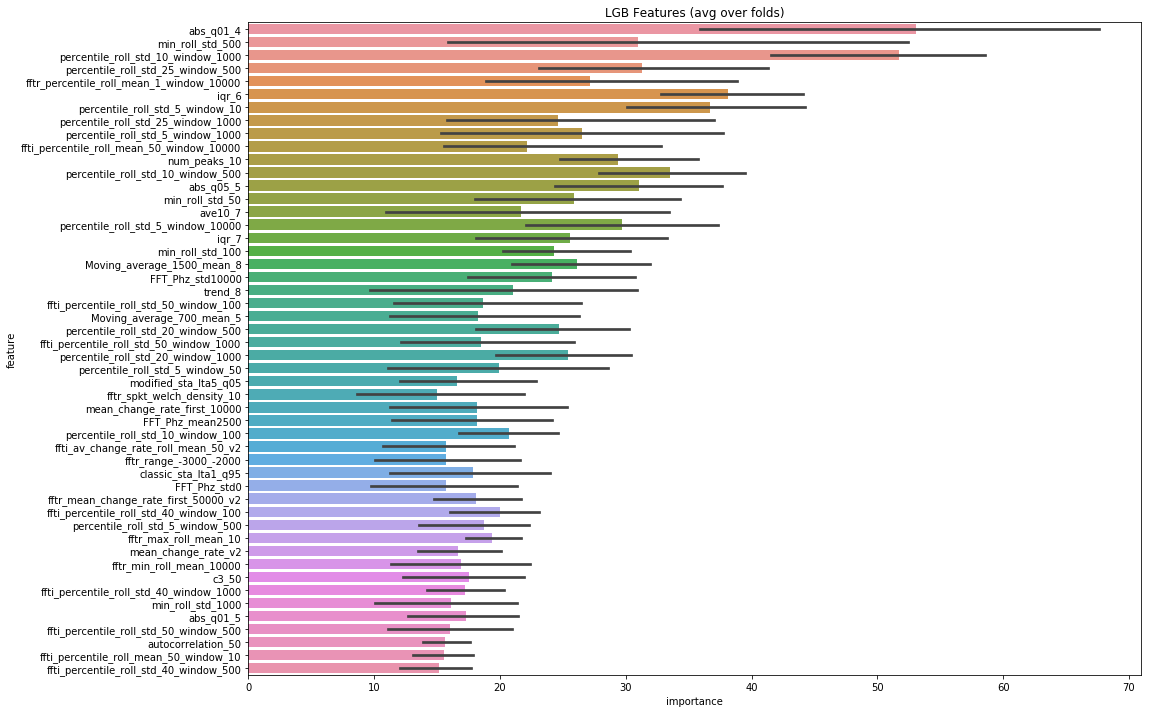

In [34]:
cols = feature_importance_lgb[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index
best_features = feature_importance_lgb.loc[feature_importance_lgb.feature.isin(cols)]
plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

### XGBoost (Gradient Boosting)

In [35]:
params_xgb = {
    'eta': 0.01, #Andrew uses 0.03
    'max_depth': 6, #Andrew uses 10
    'subsample': 0.5, #Andrew uses 0.9
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': True,
    'nthread': 32
} # CV mean score: 2.0801, std: 0.0711.
oof_xgb, prediction_xgb, scores_xgb = train_model(X=X_train_scaled,
                                                  X_test=X_test_scaled,
                                                  y=y_tr,
                                                  folds=folds_models,
                                                  params=params_xgb,
                                                  model_type='xgb',
                                                  show_scatter=False)

Fold 0 started at Sun May 12 10:35:17 2019
[0]	train-mae:5.14373	valid_data-mae:5.12573
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[257]	train-mae:1.42444	valid_data-mae:2.02122

Fold 1 started at Sun May 12 10:35:28 2019
[0]	train-mae:5.1652	valid_data-mae:5.03997
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[263]	train-mae:1.4198	valid_data-mae:2.02487

Fold 2 started at Sun May 12 10:35:39 2019
[0]	train-mae:5.11566	valid_data-mae:5.2431
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[500]	train-mae:1.07679	valid_data-mae:2.08678
Stopping. Best iteration:
[329]	train-mae:1.29243	valid_data-mae:2.08579

Fold 3 s

### SVM
Similar to NuSVC, for regression, uses a parameter nu to control the number of support vectors. However, unlike NuSVC, where nu replaces C, here nu replaces the parameter epsilon of epsilon-SVR.

In [36]:
#model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01) #original values
model = NuSVR(gamma='scale', nu=0.63, C=0.4469387755102041, tol=0.01)
oof_svr, prediction_svr, scores_svr = train_model(X=X_train_scaled,
                                      X_test=X_test_scaled,
                                      y=y_tr,
                                      folds=folds_models,
                                      params=None,
                                      model_type='sklearn',
                                      model=model,
                                      show_scatter=False)
del model

Fold 0 started at Sun May 12 10:36:17 2019
Fold 0. MAE: 2.0729.

Fold 1 started at Sun May 12 10:36:51 2019
Fold 1. MAE: 2.1151.

Fold 2 started at Sun May 12 10:37:25 2019
Fold 2. MAE: 2.1499.

Fold 3 started at Sun May 12 10:37:56 2019
Fold 3. MAE: 1.9757.

Fold 4 started at Sun May 12 10:38:28 2019
Fold 4. MAE: 2.0977.

CV mean score: 2.0823, std: 0.0589.


### Catboost

In [37]:
params_cat = {
    'loss_function':'MAE'
}
oof_cat, prediction_cat, scores_cat = train_model(X=X_train_scaled,
                                                  X_test=X_test_scaled,
                                                  y=y_tr,
                                                  folds=folds_models,
                                                  params=params_cat,
                                                  model_type='cat',
                                                  show_scatter=False)

Fold 0 started at Sun May 12 10:38:59 2019
Fold 1 started at Sun May 12 10:52:13 2019
Fold 2 started at Sun May 12 11:05:21 2019
Fold 3 started at Sun May 12 11:18:57 2019
Fold 4 started at Sun May 12 11:32:13 2019
CV mean score: 2.0004, std: 0.0774.


### Kernel Ridge
This model combines regularized linear regression with a given kernel (radial basis in this case).

In [38]:
#model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01) #Original parameters
model = KernelRidge(kernel='rbf', alpha=2.4497346938775513, gamma=0.0018461224489795917)
oof_r, prediction_r, scores_r = train_model(X=X_train_scaled,
                                            X_test=X_test_scaled,
                                            y=y_tr,
                                            folds=folds_models,
                                            params=None,
                                            model_type='sklearn',
                                            model=model,
                                            show_scatter=False)
del model

Fold 0 started at Sun May 12 11:45:24 2019
Fold 0. MAE: 2.3036.

Fold 1 started at Sun May 12 11:45:26 2019
Fold 1. MAE: 2.3031.

Fold 2 started at Sun May 12 11:45:27 2019
Fold 2. MAE: 2.3095.

Fold 3 started at Sun May 12 11:45:28 2019
Fold 3. MAE: 2.2074.

Fold 4 started at Sun May 12 11:45:29 2019
Fold 4. MAE: 2.2973.

CV mean score: 2.2842, std: 0.0386.


### Genetic Program Models

In [39]:
params_gpi = {
    'activation':'atan'
}
oof_gpi, prediction_gpi, scores_gpi = train_model(X=X_train_scaled,
                                                  X_test=X_test_scaled,
                                                  y=y_tr,
                                                  folds=folds_models,
                                                  model_type='gpi',
                                                  params=params_gpi,
                                                  show_scatter=False)

Fold 0 started at Sun May 12 11:45:30 2019
Fold 1 started at Sun May 12 11:45:31 2019
Fold 2 started at Sun May 12 11:45:32 2019
Fold 3 started at Sun May 12 11:45:33 2019
Fold 4 started at Sun May 12 11:45:34 2019
CV mean score: 1.9140, std: 0.0732.


In [40]:
params_gpi_new = {
    'activation':'atan'
}
oof_gpi_new, prediction_gpi_new, scores_gpi_new = train_model(X_train_scaled,
                                                              X_test_scaled,
                                                              y_tr,
                                                              params=params_gpi_new,
                                                              folds=folds_models,
                                                              model_type='gpi_new')

Fold 0 started at Sun May 12 11:45:36 2019
Fold 1 started at Sun May 12 11:45:36 2019
Fold 2 started at Sun May 12 11:45:37 2019
Fold 3 started at Sun May 12 11:45:38 2019
Fold 4 started at Sun May 12 11:45:38 2019
CV mean score: 1.9542, std: 0.0728.


In [41]:
params_gpii_new = {
    'activation':'atan'
}
oof_gpii_new, prediction_gpii_new, scores_gpii_new = train_model(X_train_scaled,
                                                                 X_test_scaled,
                                                                 y_tr,
                                                                 params=params_gpii_new,
                                                                 folds=folds_models,
                                                                 model_type='gpii_new')

Fold 0 started at Sun May 12 11:45:39 2019
Fold 1 started at Sun May 12 11:45:40 2019
Fold 2 started at Sun May 12 11:45:41 2019
Fold 3 started at Sun May 12 11:45:41 2019
Fold 4 started at Sun May 12 11:45:42 2019
CV mean score: 1.9698, std: 0.0731.


In [42]:
params_gpiii_new = {
    'activation':'atan'
}
oof_gpiii_new, prediction_gpiii_new, scores_gpiii_new = train_model(X_train_scaled,
                                                                    X_test_scaled,
                                                                    y_tr,
                                                                    params=params_gpiii_new,
                                                                    folds=folds_models,
                                                                    model_type='gpiii_new')

Fold 0 started at Sun May 12 11:45:43 2019
Fold 1 started at Sun May 12 11:45:44 2019
Fold 2 started at Sun May 12 11:45:44 2019
Fold 3 started at Sun May 12 11:45:45 2019
Fold 4 started at Sun May 12 11:45:46 2019
CV mean score: 1.9562, std: 0.0682.


In [43]:
params_gpi_tiny = {
    'activation':'atan'
}
oof_gpi_tiny, prediction_gpi_tiny, scores_gpi_tiny = train_model(X_train_scaled,
                                                                 X_test_scaled,
                                                                 y_tr,
                                                                 params=params_gpi_tiny,
                                                                 folds=folds_models,
                                                                 model_type='gpi_tiny')

Fold 0 started at Sun May 12 11:45:47 2019
Fold 1 started at Sun May 12 11:45:47 2019
Fold 2 started at Sun May 12 11:45:47 2019
Fold 3 started at Sun May 12 11:45:47 2019
Fold 4 started at Sun May 12 11:45:47 2019
CV mean score: 2.2715, std: 0.0515.


In [44]:
params_gpii_tiny = {
    'activation':'atan'
}
oof_gpii_tiny, prediction_gpii_tiny, scores_gpii_tiny = train_model(X_train_scaled,
                                                                    X_test_scaled,
                                                                    y_tr,
                                                                    params=params_gpii_tiny,
                                                                    folds=folds_models,
                                                                    model_type='gpii_tiny')

Fold 0 started at Sun May 12 11:45:47 2019
Fold 1 started at Sun May 12 11:45:47 2019
Fold 2 started at Sun May 12 11:45:47 2019
Fold 3 started at Sun May 12 11:45:47 2019
Fold 4 started at Sun May 12 11:45:47 2019
CV mean score: 2.3044, std: 0.0477.


### Random Forest
This regressor fits many decision trees with different subsets of the original data and average the predictions between them.

In [45]:
params_rf = {
    'max_depth': 12, #8,
    'max_features': 'log2', #'auto',
    'min_samples_leaf': 2,
    'min_samples_split': 4 #6
} #CV mean score: 2.0448, std: 0.0793.
model = RandomForestRegressor(criterion='mae', n_estimators=200, n_jobs=-1, **params_rf)
oof_rf, prediction_rf, scores_rf = train_model(X=X_train_scaled,
                                               X_test=X_test_scaled,
                                               y=y_tr,
                                               folds=folds_models,
                                               params=params_rf,
                                               model_type='sklearn',
                                               model=model,
                                               show_scatter=False)
del model

Fold 0 started at Sun May 12 11:45:47 2019
Fold 0. MAE: 2.0542.

Fold 1 started at Sun May 12 11:45:51 2019
Fold 1. MAE: 2.0485.

Fold 2 started at Sun May 12 11:45:55 2019
Fold 2. MAE: 2.1016.

Fold 3 started at Sun May 12 11:45:59 2019
Fold 3. MAE: 1.9058.

Fold 4 started at Sun May 12 11:46:02 2019
Fold 4. MAE: 2.0632.

CV mean score: 2.0347, std: 0.0671.


### Extremely Randomized Trees


In [46]:
params_ex = {
    'max_depth': 12,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 4
}
model = ExtraTreesRegressor(criterion='mae', n_estimators=200, n_jobs=-1, **params_ex)
oof_ex, prediction_ex, scores_ex = train_model(X=X_train_scaled,
                                               X_test=X_test_scaled,
                                               y=y_tr,
                                               folds=folds_models,
                                               params=params_ex,
                                               model_type='sklearn',
                                               model=model,
                                               show_scatter=False)
del model

Fold 0 started at Sun May 12 11:46:07 2019
Fold 0. MAE: 2.0246.

Fold 1 started at Sun May 12 11:46:14 2019
Fold 1. MAE: 2.0442.

Fold 2 started at Sun May 12 11:46:21 2019
Fold 2. MAE: 2.0907.

Fold 3 started at Sun May 12 11:46:29 2019
Fold 3. MAE: 1.8893.

Fold 4 started at Sun May 12 11:46:37 2019
Fold 4. MAE: 2.0506.

CV mean score: 2.0199, std: 0.0688.


### Ada Boost

In [47]:
params_ada = {
    'learning_rate': 0.001
}
base = KernelRidge(kernel='rbf', alpha=2.4497346938775513, gamma=0.0018461224489795917)
model = AdaBoostRegressor(base_estimator=base, n_estimators=100, **params_ada)
oof_ada, prediction_ada, scores_ada = train_model(X=X_train_scaled,
                                                  X_test=X_test_scaled,
                                                  y=y_tr,
                                                  folds=folds_models,
                                                  params=params_ada,
                                                  model_type='sklearn',
                                                  model=model,
                                                  show_scatter=False)
del base
del model

Fold 0 started at Sun May 12 11:46:45 2019
Fold 0. MAE: 2.3160.

Fold 1 started at Sun May 12 11:49:21 2019
Fold 1. MAE: 2.3194.

Fold 2 started at Sun May 12 11:51:58 2019
Fold 2. MAE: 2.3248.

Fold 3 started at Sun May 12 11:54:34 2019
Fold 3. MAE: 2.2196.

Fold 4 started at Sun May 12 11:57:14 2019
Fold 4. MAE: 2.3129.

CV mean score: 2.2985, std: 0.0397.


### KNN

In [48]:
#model = neighbors.KNeighborsRegressor()
#parameter_grid = {'n_neighbors': [10, 20, 25, 30, 35, 50]}
#grid_search = GridSearchCV(model, param_grid=parameter_grid,
#                           cv=folds_models,
#                           scoring='neg_mean_absolute_error',
#                           n_jobs=-1)
#grid_search.fit(X_train_scaled, y_tr)
#print('Best score: {}'.format(grid_search.best_score_))
#print('Best parameters: {}'.format(grid_search.best_params_))
#model = neighbors.KNeighborsRegressor(**grid_search.best_params_)
params_knn = {
    'n_neighbors': 10
}
model = neighbors.KNeighborsRegressor(n_neighbors=30)
oof_knn, prediction_knn, scores_knn = train_model(X=X_train_scaled,
                                                  X_test=X_test_scaled,
                                                  y=y_tr,
                                                  folds=folds_models,
                                                  params=params_knn,
                                                  model_type='sklearn',
                                                  model=model,
                                                  show_scatter=False)
del model

Fold 0 started at Sun May 12 11:59:54 2019
Fold 0. MAE: 2.1523.

Fold 1 started at Sun May 12 12:00:29 2019
Fold 1. MAE: 2.1779.

Fold 2 started at Sun May 12 12:01:04 2019
Fold 2. MAE: 2.1725.

Fold 3 started at Sun May 12 12:01:39 2019
Fold 3. MAE: 1.9580.

Fold 4 started at Sun May 12 12:02:14 2019
Fold 4. MAE: 2.1546.

CV mean score: 2.1231, std: 0.0831.


# Compare models

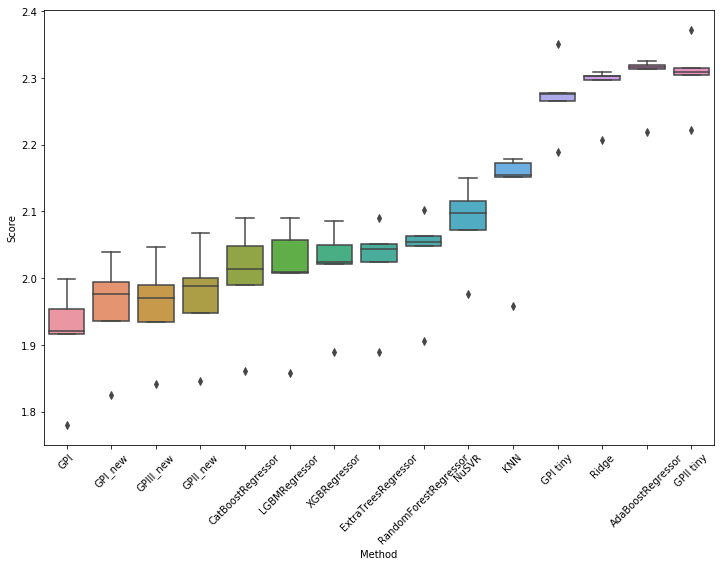

In [53]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame()
try:
    scores_df['LGBMRegressor'] = scores_lgb
except NameError:
    print('LGBMRegressor not computed')
try:
    scores_df['XGBRegressor'] = scores_xgb
except NameError:
    print('XGBRegressor not computed')
try:
    scores_df['NuSVR'] = scores_svr
except NameError:
    print('NuSVR not computed')
try:
    scores_df['CatBoostRegressor'] = scores_cat
except NameError:
    print('CatBoostRegressor not computed')
try:
    scores_df['Ridge'] = scores_r
except NameError:
    print('Ridge not computed')
try:
    scores_df['GPI'] = scores_gpi
except NameError:
    print('GPI not computed')
try:
    scores_df['GPI_new'] = scores_gpi_new
except NameError:
    print('GPI_new not computed')
try:
    scores_df['GPII_new'] = scores_gpii_new
except NameError:
    print('GPII_new not computed')    
try:
    scores_df['GPIII_new'] = scores_gpiii_new
except NameError:
    print('GPIII_new not computed')     
try:
    scores_df['RandomForestRegressor'] = scores_rf
except NameError:
    print('RandomForestRegressor not computed')
try:
    scores_df['ExtraTreesRegressor'] = scores_ex
except NameError:
    print('ExtraTreesRegressor not computed')
try:
    scores_df['AdaBoostRegressor'] = scores_ada
except NameError:
    print('AdaBoostRegressor not computed')
try:
    scores_df['KNN'] = scores_knn
except NameError:
    print('KNN not computed')
try:
    scores_df['GPI tiny'] = scores_gpi_tiny
except NameError:
    print('GPI tiny not computed')
try:
    scores_df['GPII tiny'] = scores_gpii_tiny
except NameError:
    print('GPII tiny not computed')
    
ax = sns.boxplot(data=scores_df.reindex(scores_df.mean().sort_values().index, axis=1));
#ax.set(yscale="log")

plt.xticks(rotation=45);
plt.xlabel('Method');
plt.ylabel('Score');

## Feature reduction

### ELI5 and permutation importance
ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

**Important notice**: running eli5 on all features takes a lot of time, so I run the cell below in `version 14` and printed the top-50 features. In the following versions I'll use these 50 columns and use eli5 to find top-40 of them so that it takes less time

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_scaled, y_tr, test_size=0.2)
model = lgb.LGBMRegressor(**params_lgb, n_estimators = 50000, n_jobs = -1, verbose=-1)
model.fit(X_train,
          y_train, 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          eval_metric='mae',
          verbose=10000,
          early_stopping_rounds=200)

perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, top=50, feature_names=X_train_scaled.columns.values.tolist())

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[3024]	training's l1: 1.51051	valid_1's l1: 2.04801


Weight,Feature
0.0206 ± 0.0021,percentile_roll_std_5_window_10
0.0068 ± 0.0009,iqr_6
0.0055 ± 0.0010,percentile_roll_std_25_window_100
0.0050 ± 0.0018,abs_q05_5
0.0048 ± 0.0010,q05_6
0.0047 ± 0.0018,abs_q01_4
0.0043 ± 0.0003,percentile_roll_std_5_window_500
0.0043 ± 0.0010,q95_6
0.0041 ± 0.0010,percentile_roll_std_20_window_100
0.0038 ± 0.0012,q05_7


In [55]:
top_num_features = 40
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:top_num_features]
oof_lgb_top, prediction_lgb_top, scores_lgb_top, feature_importance_lgb_top = train_model(
    X=X_train_scaled[top_features],
    X_test=X_test_scaled[top_features],
    y=y_tr,
    folds=folds_models,
    params=params_lgb,
    model_type='lgb',
    show_scatter=False)

Fold 0 started at Sun May 12 12:23:37 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[3372]	training's l1: 1.7438	valid_1's l1: 1.99412
Fold 1 started at Sun May 12 12:23:42 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2976]	training's l1: 1.76654	valid_1's l1: 1.99121
Fold 2 started at Sun May 12 12:23:46 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[3740]	training's l1: 1.70162	valid_1's l1: 2.07226
Fold 3 started at Sun May 12 12:23:51 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[4912]	training's l1: 1.68887	valid_1's l1: 1.86437
Fold 4 started at Sun May 12 12:23:57 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[3892]	training's l1: 1.69704	valid_1's l1: 2.04148
CV mean score: 1.9927, std: 0.0

### Dropping highly correlated features

Due to the huge number of features there are certainly some highly correlated features, let's try droping them!

In [56]:
X_train_scaled_uncorr = X_train_scaled.copy()
X_test_scaled_uncorr = X_test_scaled.copy()

In [57]:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = X_train_scaled_uncorr.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.99
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
X_train_scaled_uncorr = X_train_scaled_uncorr.drop(to_drop, axis=1)
X_test_scaled_uncorr = X_test_scaled_uncorr.drop(to_drop, axis=1)

print(X_train_scaled.shape)
print(X_train_scaled_uncorr.shape)

(4178, 2306)
(4178, 1113)


Fold 0 started at Sun May 12 13:06:49 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2940]	training's l1: 1.55047	valid_1's l1: 2.02684
Fold 1 started at Sun May 12 13:07:22 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[3488]	training's l1: 1.46929	valid_1's l1: 2.01729
Fold 2 started at Sun May 12 13:07:59 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[3868]	training's l1: 1.38693	valid_1's l1: 2.096
Fold 3 started at Sun May 12 13:08:39 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2827]	training's l1: 1.59917	valid_1's l1: 1.86845
Fold 4 started at Sun May 12 13:09:12 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2635]	training's l1: 1.58541	valid_1's l1: 2.0645
CV mean score: 2.0146, std: 0.078

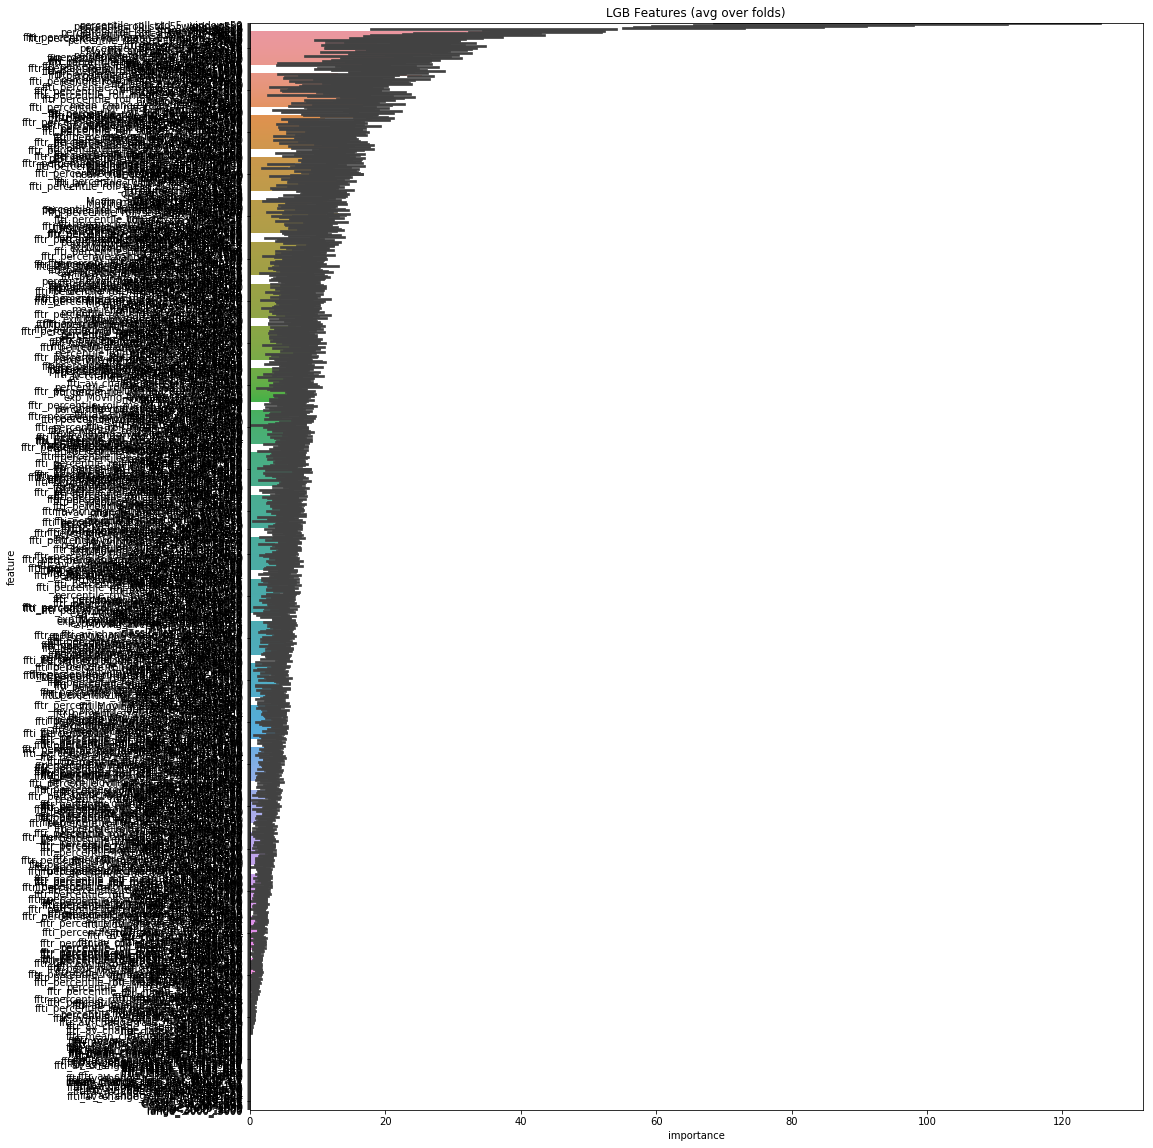

In [58]:
oof_lgb_uncorr, prediction_lgb_uncorr, scores_lgb_uncorr, feature_importance_lgb_uncorr = train_model(
    X=X_train_scaled_uncorr,
    X_test=X_test_scaled_uncorr,
    y=y_tr,
    folds=folds_models,
    params=params_lgb,
    model_type='lgb',
    show_scatter=False)
cols = feature_importance_lgb_uncorr[['feature', 'importance']].groupby('feature').mean().sort_values(
    by='importance', ascending=False).index
best_features = feature_importance_lgb_uncorr.loc[feature_importance_lgb_uncorr.feature.isin(cols)]
plt.figure(figsize=(16, 20));
sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False));
plt.title('LGB Features (avg over folds)');

In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_scaled_uncorr, y_tr, test_size=0.2)
model = lgb.LGBMRegressor(**params_lgb, n_estimators = 50000, n_jobs = -1, verbose=-1)
model.fit(X_train,
          y_train, 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          eval_metric='mae',
          verbose=10000,
          early_stopping_rounds=200)

perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)
#eli5.show_weights(perm, top=50, feature_names=X_train_scaled_uncorr.columns.values.tolist())

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2728]	training's l1: 1.59011	valid_1's l1: 1.98282


In [67]:
params_lgb = {'num_leaves': 8,
              'min_data_in_leaf': 40,
              'max_depth': 16,
              'learning_rate': 0.01,
              'bagging_freq': 4,
              'bagging_fraction': 0.7166666666666667,
              'reg_alpha': 0.19444444444444445,
              'reg_lambda': 0.19444444444444445,
              'objective': 'huber',
              'boosting': 'gbdt',
              'verbosity': -1,
              'random_seed': 19,
              'metric': 'mae',
              'bagging_seed': 11
             }

top_num_features = 40
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:top_num_features]
oof_lgb_uncorr_top, prediction_lgb_uncorr_top, scores_lgb_uncorr_top, feature_importance_lgb_uncorr_top = train_model(
    X=X_train_scaled_uncorr[top_features],
    X_test=X_test_scaled_uncorr[top_features],
    y=y_tr,
    folds=folds_models,
    params=params_lgb,
    model_type='lgb',
    show_scatter=False)

Fold 0 started at Sun May 12 14:02:18 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[3018]	training's l1: 1.66548	valid_1's l1: 1.98427
Fold 1 started at Sun May 12 14:02:21 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2368]	training's l1: 1.71372	valid_1's l1: 2.00521
Fold 2 started at Sun May 12 14:02:25 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2896]	training's l1: 1.64729	valid_1's l1: 2.08347
Fold 3 started at Sun May 12 14:02:28 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2020]	training's l1: 1.78035	valid_1's l1: 1.88149
Fold 4 started at Sun May 12 14:02:31 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2200]	training's l1: 1.72344	valid_1's l1: 2.0453
CV mean score: 1.9999, std: 0.0

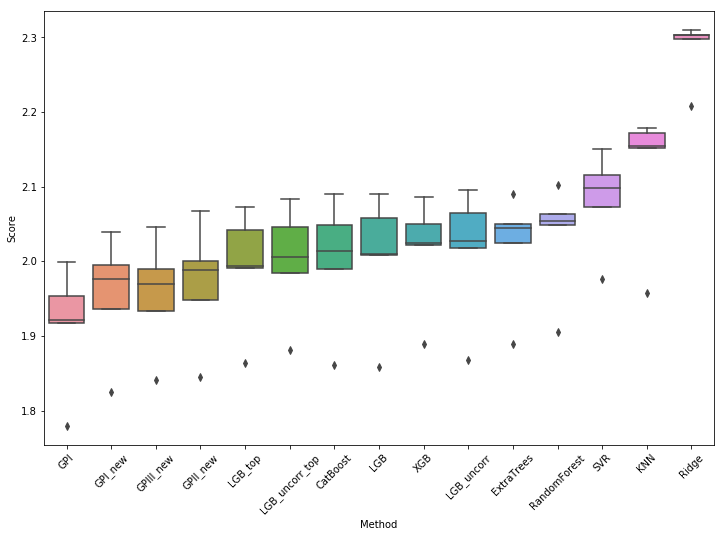

In [68]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame()

try:
    scores_df['LGB'] = scores_lgb
except NameError:
    print('LGB not computed')
try:
    scores_df['LGB_top'] = scores_lgb_top
except NameError:
    print('LGB_top not computed')
try:
    scores_df['LGB_uncorr'] = scores_lgb_uncorr
except NameError:
    print('LGB_uncorr not computed')
try:
    scores_df['LGB_uncorr_top'] = scores_lgb_uncorr_top
except NameError:
    print('LGB_uncorr_top not computed')
try:
    scores_df['XGB'] = scores_xgb
except NameError:
    print('XGB not computed')
try:
    scores_df['SVR'] = scores_svr
except NameError:
    print('SVR not computed')
try:
    scores_df['CatBoost'] = scores_cat
except NameError:
    print('CatBoost not computed')
try:
    scores_df['Ridge'] = scores_r
except NameError:
    print('Ridge not computed')
try:
    scores_df['GPI'] = scores_gpi
except NameError:
    print('GPI not computed')
try:
    scores_df['GPI_new'] = scores_gpi_new
except NameError:
    print('GPI_new not computed')
try:
    scores_df['GPII_new'] = scores_gpii_new
except NameError:
    print('GPII_new not computed')    
try:
    scores_df['GPIII_new'] = scores_gpiii_new
except NameError:
    print('GPIII_new not computed')     
try:
    scores_df['RandomForest'] = scores_rf
except NameError:
    print('RandomForest not computed')     
try:
    scores_df['ExtraTrees'] = scores_ex
except NameError:
    print('ExtraTrees not computed') 
try:
    scores_df['KNN'] = scores_knn
except NameError:
    print('KNN not computed') 
    
ax = sns.boxplot(data=scores_df.reindex(scores_df.mean().sort_values().index, axis=1));
#ax.set(yscale="log")

plt.xticks(rotation=45);
plt.xlabel('Method');
plt.ylabel('Score');

In [ ]:
prediction_blend_gp = (prediction_gpi +
                    prediction_gpi_new + 
                    prediction_gpii_new + 
                    prediction_gpiii_new) / 4
oof_blend_gp = (oof_gpi +
             oof_gpi_new + 
             oof_gpii_new + 
             oof_gpiii_new) / 4

In [ ]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_blend_gp
submission.to_csv('../output/submission_blend_gp.csv')

In [ ]:
#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')